# Пайплайны

Как говорилось ранее, **пайплайн** — это автоматизированный поэтапный процесс выполнения манипуляций с данными, включающий в себя сбор, обработку, генерацию и отбор признаков, обучение модели с последующей её настройкой и проверкой качества. 

Основные цели использования пайплайнов — автоматизация, ускорение вычислений с использованием многопоточности в Python и дальнейшее развертывание пайплайна для использования в периодических расчетах (сбор данных в режиме онлайн/онлайн-работа модели). Кроме того, пайплайны хороши в случае, когда надо подобрать оптимальные гиперпараметры для всего цикла обработки данных и последующего обучения. 

В библиотеке scikit-learn пайплайны реализованы как класс **sklearn.pipeline.Pipeline()**. Этот класс может быть использован для сбора воедино отбора и обработки данных вместе с итоговой моделью. 

Внутренние преобразования должны реализовывать методы **fit()** и **transform()** (либо **fit_transform()** в отдельных случаях).

## Создание пайплайна

**California Housing Dataset**

- **MedInc** — медианный уровень дохода в квартале;

- **HouseAge** — медианный возраст дома в квартале;

- **AveRooms** — среднее количество помещений;

- **AveBedrms** — среднее количество спальных комнат;

- **Population** — население квартала;

- **AveOccup** — средний срок проживания;

- **Latitude** — значение широты квартала;

- **Longitude** — значение долготы квартала;

- **Price** — целевое значение.


Загрузим датасет и посмотрим на него:

In [68]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
 
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
 
data = fetch_california_housing()
df = pd.DataFrame(data['data'], columns=data['feature_names'])
df.loc[:,'target'] = data['target']
df.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


> Определимся с метрикой, по которой будем оценивать качество модели — Root Mean Squared Error (RMSE), корень из среднего квадрата отклонения. Для этого на метод mean_squared_error подадим атрибут squared = False, который позволяет управлять возведением метрики в квадрат. Помимо RMSE для оценки качества модели будем использовать метрику R2.

In [69]:
def rmse(y_hat, y):
    rmse = np.sqrt(mean_squared_error(y_hat, y))
    return rmse

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Видим, что данные исключительно типа float, поэтому мы можем в качестве предобработки применить к ним **StandardScaler()**.

Разделим данные на обучающую и тестовую выборки, используя **train_test_split**: 

In [71]:
X = df.drop('target', axis=1)
Y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)
print(f'Размер обучающей выборки {X_train.shape}')
print(f'Размер тестовой выборки {X_test.shape}')

Размер обучающей выборки (15480, 8)
Размер тестовой выборки (5160, 8)


Обучим простейший пайплайн, вызвав метод **fit()**, состоящий из случайного леса и стандартизации (**StandardScaler**). На вход пайплайна подается список из преобразований в формате кортежа (название метода преобразования, по которому мы будем обращаться в дальнейшем к нашему преобразованию, объект  метода преобразования). Например:

In [72]:
pipeline = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestRegressor())])

Посмотрим на метрики. Для этого сделаем предсказание пайплайном с помощью метода **predict()** и посчитаем *R2* и *RMSE* с помощью функций **r2_score()** и **rmse()** соответственно. Округлим результат до четырёх цифр после запятой.

In [73]:
y_pred = pipeline.predict(X_test)
print(f'Качество по метрике R2: {round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.8062
Качество по RSME: 0.5065


Теперь мы можем посмотреть на все параметры в пайплайне, вызвав метод **get_params():**

> Примечание. В качестве альтернативного метода задания пайплайна можно использовать метод make_pipeline, на вход которого подаются объекты, которые будут использованы в пайплайне. В нашем случае:

> from sklearn.pipeline import make_pipeline

> make_pipeline(StandardScaler(), RandomForestRegressor())

>Использование пайплайна в виде, полученном из make_pipeline, аналогично. 

In [76]:
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('rf', RandomForestRegressor(max_depth=100))],
 'transform_input': None,
 'verbose': False,
 'scaler': StandardScaler(),
 'rf': RandomForestRegressor(max_depth=100),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': 100,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__monotonic_cst': None,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': None,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [75]:
pipeline.set_params(rf__max_depth = 100)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(max_depth=100))])

Попробуем теперь обратиться к отдельной части пайплайна. Попробуем вызвать значение **n_estimator** у случайного леса. Мы можем это сделать двумя способами: индексацией пайплайна или обращением через имя, которые мы задали ранее при создании ('rf').

In [23]:
print(pipeline[1].n_estimators)
print(pipeline['rf'].n_estimators)

print(pipeline[1].max_depth)
print(pipeline['rf'].max_depth)

100
100
None
None


Теперь попробуем задать этому же параметру значение 200. Можно это сделать, используя метод set_params(), на вход которого надо подавать конструкцию **<название модуля>__<название параметра>.**

> Обратите внимание на **два нижних подчеркивания**, которые используются в качестве литералов для разбиения названия модуля и названия его параметра. Без него компилятор будет неправильно интерпретировать параметр, который вы хотите изменить!

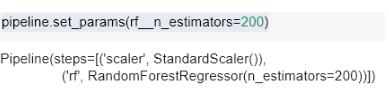

Данную структуру надо учитывать, когда для пайплайна задается GridSearch кросс-валидация. Попробуем взять 100, 200, 500 базовых моделей и сделать поиск оптимального параметра StardardScaler with_mean (типа bool, который отвечает за центровку данных, приводит распределение к нулевому среднему, по умолчанию — True. В противном случае среднее данных остается неизменным):

In [21]:
from sklearn.model_selection import GridSearchCV
param_grid = {'scaler__with_mean':[True,False],
              'rf__n_estimators':[100, 200, 500]}
grid_search = GridSearchCV(pipeline, param_grid=param_grid, verbose = True)


grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('rf', RandomForestRegressor(n_estimators=500))])


In [22]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(f'Качество по метрике R2: { round(r2_score(y_test, y_pred),4)}')
print(f'Качество по RSME: {round(rmse(y_test, y_pred),4)}')

Качество по метрике R2: 0.8096
Качество по RSME: 0.502


> Как видим, качество улучшилось по обеим метрикам.

## Предобработка в пайплайнах

При использовании пайплайна для сборки обработки данных в один стек удобно воспользоваться Column Transformer.

Column Transformer — это специальный объект из модуля compose библиотеки sklearn, который позволяет применять набор трансформаций к данным. Этот объект позволяет преобразовывать разные столбцы или подмножества столбцов входных данных по отдельности, а результаты, сгенерированные каждым преобразователем, будут объединены в единую таблицу.

Однако, самим Column Transformer пользоваться не совсем удобно, для более удобной работы с ним мы будем использовать «обёртку» в виде функции make_column_transformer() из того же модуля библиотеки sklearn.

Для начала загрузим данные и посмотрим на них:

In [25]:
df_wine= pd.read_csv('data/Red.csv')
df_wine.head()

,Name,Country,Region,Winery,Rating,NumberOfRatings,Price,Year
0,Pomerol 2011,France,Pomerol,Château La Providence,4.2,100,95.00,2011
1,Lirac 2017,France,Lirac,Château Mont-Redon,4.3,100,15.50,2017
2,Erta e China Rosso di Toscana 2015,Italy,Toscana,Renzo Masi,3.9,100,7.45,2015
3,Bardolino 2019,Italy,Bardolino,Cavalchina,3.5,100,8.72,2019
4,Ried Scheibner Pinot Noir 2016,Austria,Carnuntum,Markowitsch,3.9,100,29.15,2016


In [26]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8666 entries, 0 to 8665
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             8666 non-null   object 
 1   Country          8666 non-null   object 
 2   Region           8666 non-null   object 
 3   Winery           8666 non-null   object 
 4   Rating           8666 non-null   float64
 5   NumberOfRatings  8666 non-null   int64  
 6   Price            8666 non-null   float64
 7   Year             8666 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 541.8+ KB


Например, у нас есть численный признак цена вина (Price) и категориальный регион производства (Region). Для первого надо применить **StandardScaler()**, для второго — **OneHotEncoder()**. Мы можем сделать это следующим образом:

In [40]:
ct = make_column_transformer(
     (StandardScaler(), ['Price']),
    (OneHotEncoder(), ['Country']))
print(ct)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(), ['Price']),
                                ('onehotencoder', OneHotEncoder(),
                                 ['Country'])])


> **Примечание.** Если мы хотим применить, например, OneHotEncoder, к более чем одному признаку, то просто достаточно добавить в список колонки, например ['Country', ‘Region’]. Теперь OneHotEncoder будет работать не только на признаке Country, но ещё и на Region.

> **Примечание.** Можно также использовать фильтрацию по типу колонок, используя метод make_column_selector() из sklearn.compose. Например, следующий Column Transformer будет применять преобразование StandardScaler к числовым столбцам и OneHotEncoder к столбцам с типом данных object:

In [30]:
from sklearn.compose import make_column_selector
import numpy as np

ct_filtered = make_column_transformer(
       (StandardScaler(), make_column_selector(dtype_include=np.number)),
       (OneHotEncoder(), make_column_selector(dtype_include=object))
)

print(ct_filtered)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F600064AD0>),
                                ('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001F6000650D0>)])


Полученный трансформер можно использовать в качестве элемента пайплайна, например: 

In [31]:
pipeline = Pipeline([('ct', ct), ('rf', RandomForestRegressor())])

Давайте посмотрим на результат работы *ColumnTransformer* в пайплайне. Для этого обучим его на колонках *Price* и *Country*, а в качестве целевой метки используем рейтинг вина *Rating*.

In [32]:
X = df_wine[['Country', 'Price']]
y = df_wine['Rating']
pipeline.fit(X, y)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country'])])),
                ('rf', RandomForestRegressor())])

> **Примечание.** В рамках этого примера мы обучаем пайплайн на полной выборке. Применяя эти знания на практике, не забудьте предварительно разделить данные на тренировочную и тестовую выборки, как мы делали это в первой части юнита. Во избежание утечки данных обучайте пайплайн на тренировочной выборке.

Теперь вызовем отдельно ct и преобразуем X. 

> **Важный момент:** при отображении после преобразования ваш датасет будет представлен в виде **sparse-матрицы** (специальный формат для хранения больших, практически полностью нулевых матриц), поэтому надо будет вызвать метод **toarray().** Так же мы можем получить названия колонок с onehotencoder с помощью метода **.get_feature_names_out()**, обратившись именно к энкодеру. 

In [ ]:
pipeline['ct'].transformers_[1][1].get_feature_names_out() #Вывод результатов OneHotEncoder

array(['Country_Argentina', 'Country_Australia', 'Country_Austria',
       'Country_Brazil', 'Country_Bulgaria', 'Country_Canada',
       'Country_Chile', 'Country_China', 'Country_Croatia',
       'Country_France', 'Country_Georgia', 'Country_Germany',
       'Country_Greece', 'Country_Hungary', 'Country_Israel',
       'Country_Italy', 'Country_Lebanon', 'Country_Mexico',
       'Country_Moldova', 'Country_New Zealand', 'Country_Portugal',
       'Country_Romania', 'Country_Slovakia', 'Country_Slovenia',
       'Country_South Africa', 'Country_Spain', 'Country_Switzerland',
       'Country_Turkey', 'Country_United States', 'Country_Uruguay'],
      dtype=object)

In [56]:
pd.DataFrame(
    pipeline['ct'].transform(X).toarray(),
    columns=['Price'] + pipeline['ct'].transformers_[1][1].get_feature_names_out().tolist()
)

,Price,Country_Argentina,Country_Australia,Country_Austria,Country_Brazil,Country_Bulgaria,Country_Canada,Country_Chile,Country_China,Country_Croatia,...,Country_Portugal,Country_Romania,Country_Slovakia,Country_Slovenia,Country_South Africa,Country_Spain,Country_Switzerland,Country_Turkey,Country_United States,Country_Uruguay
0,0.657648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.278402,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.373184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.358231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.117684,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8661,-0.266981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8662,-0.224358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8663,-0.178910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8664,-0.387784,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


⭐️ Итак, мы научились использовать и собирать полноценный пайплайн, узнали о трансформациях колонок, которые позволяют легко и просто делать рутинные задачи типа нормализации/стандартизации и кодирования категориальных признаков. 

Обученный пайплайн можно сохранить в формат [pickle](https://docs.python.org/3/library/pickle.html), например, используя библиотеку joblib. Далее его можно использовать после десериализации как решение «из коробки», применяя следующие методы.

> **Примечание.** Формат *pickle* реализует двоичный протокол для сериализации/десериализации объектов для сохранения и последующего использования без каких-либо дополнительных преобразований. Удобен для переноса обученных моделей, предобработки и так далее.

> **Сериализация** — процесс перевода структуры данных в последовательность битов. 

> **Десериализация** — процесс создания из последовательности битов  структуры данных.

!pip install joblib

In [34]:
import joblib
joblib.dump(pipeline, 'pipeline.pkl')

['pipeline.pkl']

После этого ваш пайплайн будет сохранен в файл pipeline.pkl. Вы можете использовать свой пайплайн, импортировав все библиотеки из зависимостей (которые импортировались при создании пайплайна), используя следующие строчки кода:

In [35]:
pipeline_loaded = joblib.load('pipeline.pkl')
print(pipeline_loaded)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(), ['Price']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Country'])])),
                ('rf', RandomForestRegressor())])


Таким образом, мы можем использовать уже готовый пайплайн, например для проведения онлайн расчётов и постановки модели на постоянный регулярный расчёт. Под онлайн-расчётами мы подразумеваем сбор данных в формате онлайн и получения результатов модели в онлайне с помощью фреймворка, например [AirFlow](https://airflow.apache.org/). Это необходимо для раскатки решения, например, на сайте (модель рекомендаций фильмов, схожие товары в интернет магазинах и так далее).

### Задание 5.1

В каком модуле scikit-learn реализованы пайплайны?

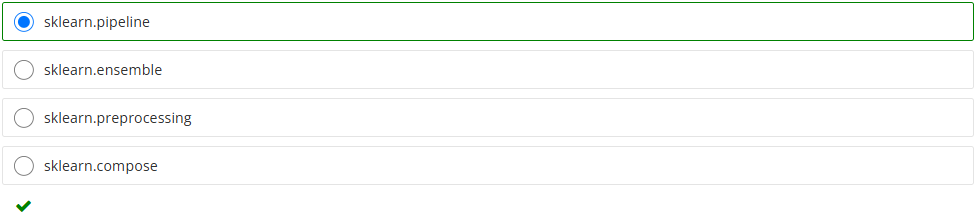

### Задание 5.2

Какие утверждения о пайплайнах верны?

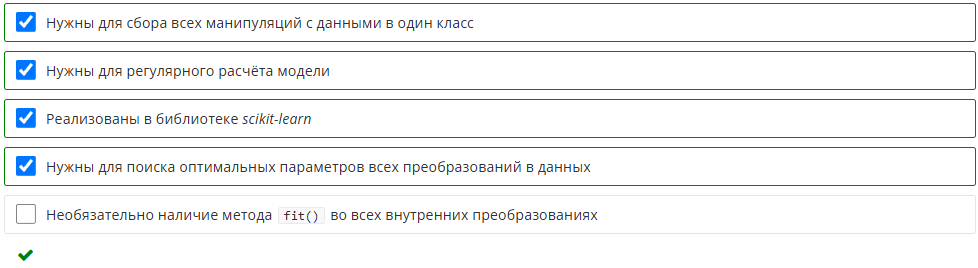

### Задание 5.3

В пайплайне pipeline есть модель под названием model, и у неё есть параметр important_parameter. Как можно задать значение 100 этому параметру?

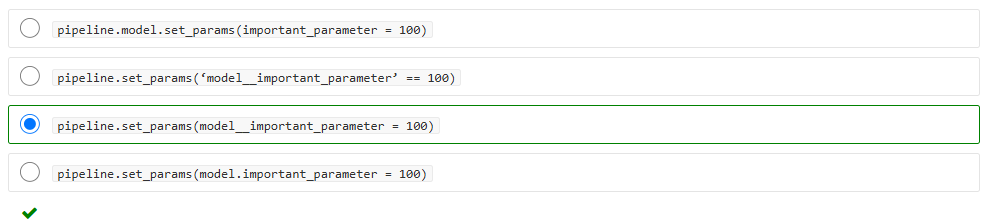

### Задание 5.4

Мы хотим в пайплайне pipeline, состоящем из последовательных действий, обратиться к третьему модулю (module_3) и посмотреть его параметр param. Как мы можем это сделать? Выберите все верные варианты.

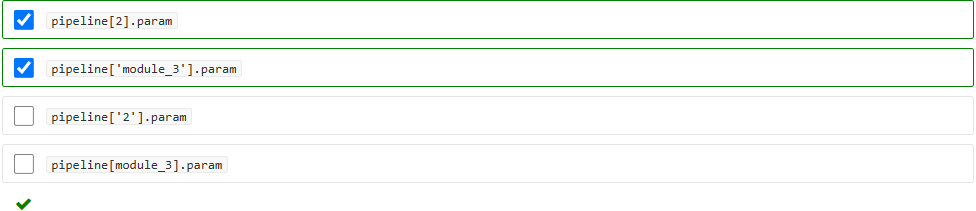